In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    make_scorer,
)

In [7]:
path = '../data/steel.csv'
data = pd.read_csv(path)
feature_cols = [
    "normalising_temperature",
    "tempering_temperature",
    "percent_silicon",
    "percent_chromium",
    "percent_copper",
    "percent_nickel",
    "percent_sulphur",
    "percent_carbon",
    "percent_manganese",
]

X = data[feature_cols]
y = data["tensile_strength"]

In [8]:
#scoring setup
mae_scorer = "neg_mean_absolute_error"

mape_scorer = make_scorer(
    mean_absolute_percentage_error,
    greater_is_better=False,
)

In [9]:
#baseline rf regressor
rf_default = RandomForestRegressor(
    random_state=1,
    n_jobs=-1,
)
#10-fold cv on baseline model
cv_results_default = cross_validate(
    rf_default,
    X,
    y,
    cv=10,
    scoring={"mae": mae_scorer, "mape": mape_scorer},
    return_train_score=True,
)

#converting negative values
train_mae = -cv_results_default["train_mae"]
test_mae = -cv_results_default["test_mae"]
train_mape = -cv_results_default["train_mape"]
test_mape = -cv_results_default["test_mape"]

print("\n_____Default Hyperparameters (RandomForestRegressor)_____")
print(f"Mean TRAIN MAE  over 10 folds: {train_mae.mean():.3f}")
print(f"Mean TEST  MAE  over 10 folds: {test_mae.mean():.3f}")
print(f"Mean TRAIN MAPE over 10 folds: {train_mape.mean():.3f}")
print(f"Mean TEST  MAPE over 10 folds: {test_mape.mean():.3f}")


_____Default Hyperparameters (RandomForestRegressor)_____
Mean TRAIN MAE  over 10 folds: 7.754
Mean TEST  MAE  over 10 folds: 34.700
Mean TRAIN MAPE over 10 folds: 0.050
Mean TEST  MAPE over 10 folds: 0.222


In [18]:
#grid search setup
rf_base = RandomForestRegressor(
    random_state=1,
    n_jobs=-1,
)

#hyperparam tuning
param_grid = {
    "n_estimators": [1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700],
    "max_depth": [None, 1, 2, 4, 6, 8, 10, 15, 20, 25, 35, 45, 55, 60, 65, 70, 75],
}

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=10,
    scoring=mae_scorer,
    return_train_score=True,
    n_jobs=-1,
)

grid_search.fit(X, y)

print("\n_____Best hyperparameters (RandomForestRegressor)_____")
print(grid_search.best_params_)
print(f"Best mean CV MAE (negative in sklearn): {grid_search.best_score_:.3f}")
print(f"Best mean CV MAE (positive): {-grid_search.best_score_:.3f}")


_____Best hyperparameters (RandomForestRegressor)_____
{'max_depth': None, 'n_estimators': 350}
Best mean CV MAE (negative in sklearn): -33.903
Best mean CV MAE (positive): 33.903


In [19]:
cv_df = pd.DataFrame(grid_search.cv_results_) 
cols_to_show = [ 
    "param_n_estimators", 
    "param_max_depth", 
    "mean_train_score", 
    "mean_test_score", 
] 
print("\n_____Grid search results (MAE, negative)_____") 
print(cv_df[cols_to_show].sort_values("mean_test_score", ascending=False))


_____Grid search results (MAE, negative)_____
     param_n_estimators param_max_depth  mean_train_score  mean_test_score
232                 350              65         -7.658609       -33.902775
248                 350              70         -7.658609       -33.902775
184                 350              45         -7.658609       -33.902775
152                 350              25         -7.658609       -33.902775
8                   350            None         -7.658609       -33.902775
..                  ...             ...               ...              ...
26                  450               1        -57.873050       -63.592720
27                  500               1        -57.941110       -63.596168
18                   50               1        -57.627918       -63.682723
17                   10               1        -58.450144       -63.921700
16                    1               1        -63.198186       -71.403357

[272 rows x 4 columns]


In [20]:
#looking at some of the results
depth_10 = cv_df[cv_df["param_max_depth"] == 10]

n_estimators_list = depth_10["param_n_estimators"].astype(int)
mean_test_mae = -depth_10["mean_test_score"]  #converting to positive

for n, err in zip(n_estimators_list, mean_test_mae):
    print(f"n_estimators={n}, mean TEST MAE={err:.3f}")

n_estimators=1, mean TEST MAE=49.054
n_estimators=10, mean TEST MAE=36.914
n_estimators=50, mean TEST MAE=35.053
n_estimators=100, mean TEST MAE=34.435
n_estimators=150, mean TEST MAE=34.337
n_estimators=200, mean TEST MAE=34.280
n_estimators=250, mean TEST MAE=34.235
n_estimators=300, mean TEST MAE=34.147
n_estimators=350, mean TEST MAE=34.165
n_estimators=400, mean TEST MAE=34.176
n_estimators=450, mean TEST MAE=34.174
n_estimators=500, mean TEST MAE=34.231
n_estimators=550, mean TEST MAE=34.264
n_estimators=600, mean TEST MAE=34.329
n_estimators=650, mean TEST MAE=34.289
n_estimators=700, mean TEST MAE=34.259


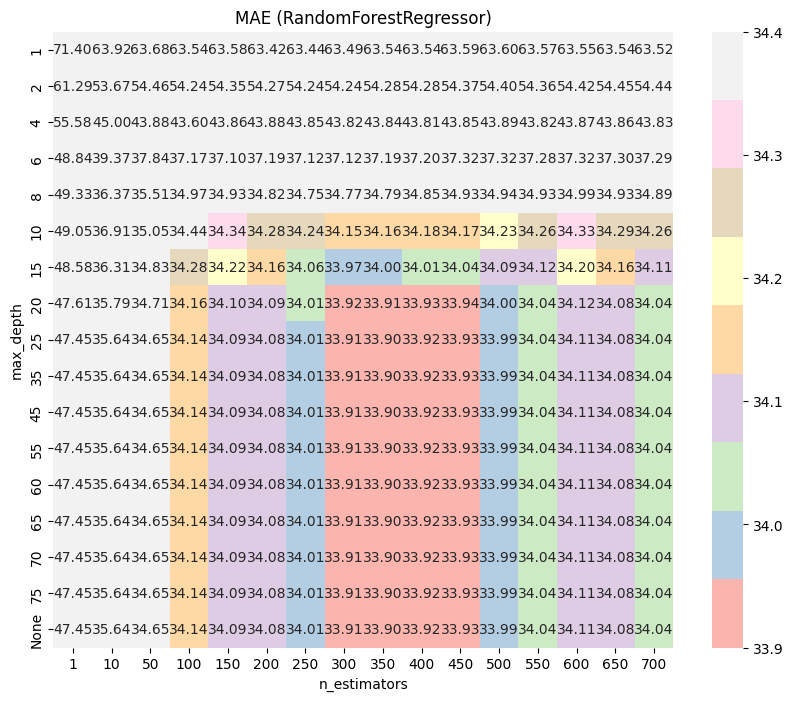

In [21]:
#converting results into dataframe for heatmap
cv_df = pd.DataFrame(grid_search.cv_results_)

#converting to positive
cv_df["test_MAE"] = -cv_df["mean_test_score"]

#handling max_depth=None (bc its NaN)
max_real_depth = cv_df["param_max_depth"].dropna().max()

#for sorting
cv_df["max_depth_num"] = cv_df["param_max_depth"].apply(
    lambda x: max_real_depth + 1 if pd.isna(x) else int(x)
)
#string label for display
cv_df["max_depth_label"] = cv_df["param_max_depth"].apply(
    lambda x: "None" if pd.isna(x) else str(int(x))
)

heatmap_data = cv_df.pivot_table(
    values="test_MAE",
    index="max_depth_label",
    columns="param_n_estimators",
)

#reordering so None is last
order = (
    cv_df[["max_depth_label", "max_depth_num"]]
    .drop_duplicates()
    .sort_values("max_depth_num")
)

heatmap_data = heatmap_data.reindex(order["max_depth_label"])

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="Pastel1",
    fmt=".2f",
    #for better colour spread
    vmin=33.90,
    vmax=34.4
)
plt.title("MAE (RandomForestRegressor)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()